In [ ]:
import pandas as pd
import numpy as np
import random
import requests
from sklearn.cluster import KMeans
from geopy.distance import great_circle
import networkx as nx
import matplotlib.pyplot as plt

c:\Users\tejas\OneDrive\Desktop\major_project\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [62]:
import pandas as pd
import random
from geopy.distance import geodesic
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
import numpy as np

# Function to generate random customer data with additional features
def generate_random_customers(center_lat, center_lon, radius_km, num_customers):
    """Generate a DataFrame of random customer data within a certain radius."""
    
    def random_coordinates(center_lat, center_lon, radius_km):
        radius_in_degrees = radius_km / 111  # Approx. 111 km per degree latitude
        lat = center_lat + random.uniform(-radius_in_degrees, radius_in_degrees)
        lon = center_lon + random.uniform(-radius_in_degrees, radius_in_degrees)
        return lat, lon

    time_slots = ['9-11 AM', '10-12 AM', '1-3 PM', '2-4 PM', '4-6 PM']
    preferences = ['fast', 'standard', 'premium']
    
    customer_data = {
        'customer_id': [i for i in range(1, num_customers + 1)],
        'latitude': [],
        'longitude': [],
        'preferred_time_slot': [random.choice(time_slots) for _ in range(num_customers)],
        'customer_preference': [random.choice(preferences) for _ in range(num_customers)],
        'demand_density': [random.randint(10, 100) for _ in range(num_customers)]  # Random demand density
    }

    for _ in range(num_customers):
        lat, lon = random_coordinates(center_lat, center_lon, radius_km)
        customer_data['latitude'].append(lat)
        customer_data['longitude'].append(lon)

    df = pd.DataFrame(customer_data)
    
    # Calculate distance to the central point for each customer
    def calculate_distance(lat1, lon1, lat2, lon2):
        return geodesic((lat1, lon1), (lat2, lon2)).km
    
    central_point = (center_lat, center_lon)
    df['distance_to_central_point'] = df.apply(
        lambda row: calculate_distance(row['latitude'], row['longitude'], central_point[0], central_point[1]),
        axis=1
    )

    return df
# Define center point and radius
center_latitude = 28.6139  # Example: New Delhi
center_longitude = 77.2090
radius_kilometers = 5  # Radius in kilometers
num_customers = 200

# Generate random customer data
customers_df = generate_random_customers(center_latitude, center_longitude, radius_kilometers, num_customers)
customers_df.head()

,customer_id,latitude,longitude,preferred_time_slot,customer_preference,demand_density,distance_to_central_point
0,1,28.584228,77.223788,2-4 PM,fast,35,3.592614
1,2,28.587741,77.228822,9-11 AM,standard,88,3.487737
2,3,28.582302,77.192491,2-4 PM,premium,33,3.856320
3,4,28.652978,77.176107,2-4 PM,fast,60,5.394649
4,5,28.602677,77.171552,4-6 PM,premium,71,3.868028


In [63]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import numpy as np
from geopy.distance import geodesic



# Step 1: Calculate Geographic Proximity (Distance to another point, e.g., central point)
def calculate_distance(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).km

# Assuming the central point for proximity calculation
central_point = (12.9716, 77.5946)  # Latitude, Longitude of a central location (e.g., city center)

customers_df['distance_to_central_point'] = customers_df.apply(
    lambda row: calculate_distance(row['latitude'], row['longitude'], central_point[0], central_point[1]),
    axis=1
)

# Step 2: Encode customer preferences (One-hot encoding)
encoder = OneHotEncoder(sparse_output=False)
encoded_preferences = encoder.fit_transform(customers_df[['customer_preference']])
encoded_preferences_df = pd.DataFrame(encoded_preferences, columns=encoder.categories_[0], index=customers_df.index)

# Step 3: Combine all features for clustering
# Including 'latitude', 'longitude', 'demand_density', 'distance_to_central_point', and encoded preferences
features = ['latitude', 'longitude', 'demand_density', 'distance_to_central_point'] + list(encoded_preferences_df.columns)
combined_features_df = pd.concat([customers_df[features[:-len(encoded_preferences_df.columns)]], encoded_preferences_df], axis=1)

# Step 4: Normalize the features
scaler = StandardScaler()
normalized_features = scaler.fit_transform(combined_features_df)

# Step 5: Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # You can change the number of clusters (n_clusters)
customers_df['kmeans_cluster'] = kmeans.fit_predict(normalized_features)

# Step 6: Evaluate clustering performance
silhouette = silhouette_score(normalized_features, customers_df['kmeans_cluster'])
davies_bouldin = davies_bouldin_score(normalized_features, customers_df['kmeans_cluster'])
calinski_harabasz = calinski_harabasz_score(normalized_features, customers_df['kmeans_cluster'])

# Display the results
print("Silhouette Score:", silhouette)
print("Davies-Bouldin Index:", davies_bouldin)
print("Calinski-Harabasz Index:", calinski_harabasz)

# Output the dataframe with cluster labels
print(customers_df)


Silhouette Score: 0.24632342938967347
Davies-Bouldin Index: 1.7352717143002179
Calinski-Harabasz Index: 49.9767291839708
     customer_id   latitude  longitude preferred_time_slot  \
0              1  28.584228  77.223788              2-4 PM   
1              2  28.587741  77.228822             9-11 AM   
2              3  28.582302  77.192491              2-4 PM   
3              4  28.652978  77.176107              2-4 PM   
4              5  28.602677  77.171552              4-6 PM   
..           ...        ...        ...                 ...   
195          196  28.641101  77.167116            10-12 AM   
196          197  28.574511  77.188781            10-12 AM   
197          198  28.633161  77.187406            10-12 AM   
198          199  28.586410  77.187112              2-4 PM   
199          200  28.595047  77.208818            10-12 AM   

    customer_preference  demand_density  distance_to_central_point  \
0                  fast              35                1729.0467

In [64]:
# Assign delivery personnel to each cluster based on time slot
def assign_delivery_personnel(customers_df):
    """Assign delivery personnel to each customer based on their cluster and time slot."""
    
    personnel_assigned = {}
    
    # Group customers by their preferred time slot
    for time_slot in customers_df['preferred_time_slot'].unique():
        # Filter the customers who prefer the current time slot
        time_slot_df = customers_df[customers_df['preferred_time_slot'] == time_slot]
        
        # Assign delivery personnel based on cluster number
        time_slot_df['delivery_personnel'] = [
            f"Personnel_{cluster}" for cluster in time_slot_df['kmeans_cluster']
        ]
        
        # Store the dataframe with assigned personnel for each time slot
        personnel_assigned[time_slot] = time_slot_df
        
    return personnel_assigned

# Assuming 'customers_df' is already clustered with 'kmeans_cluster'
clustered_customers_with_personnel = assign_delivery_personnel(customers_df)

# Display the result for the '9-11 AM' time slot
print(clustered_customers_with_personnel['9-11 AM'].head())


    customer_id   latitude  longitude preferred_time_slot customer_preference  \
1             2  28.587741  77.228822             9-11 AM            standard   
5             6  28.597298  77.209210             9-11 AM            standard   
9            10  28.594986  77.218554             9-11 AM            standard   
10           11  28.654257  77.216832             9-11 AM             premium   
13           14  28.602864  77.232719             9-11 AM            standard   

    demand_density  distance_to_central_point  kmeans_cluster  \
1               88                1729.424446               2   
5               11                1730.529127               0   
9               99                1730.250884               2   
10              69                1736.821977               1   
13              73                1731.091285               0   

   delivery_personnel  
1         Personnel_2  
5         Personnel_0  
9         Personnel_2  
10        Personnel_1  
13

C:\Users\tejas\AppData\Local\Temp\ipykernel_22036\2263105342.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_slot_df['delivery_personnel'] = [
C:\Users\tejas\AppData\Local\Temp\ipykernel_22036\2263105342.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_slot_df['delivery_personnel'] = [
C:\Users\tejas\AppData\Local\Temp\ipykernel_22036\2263105342.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

In [65]:
import networkx as nx
import requests

HERE_API_KEY = 'Ur5mcEt5nP9kQNySgZFeILZ6HyxBJmJOMHabtjorKVQ'

def get_distance_data(origin, destination):
    """Fetch distance data between two geographical points using HERE API."""
    url = f"https://router.hereapi.com/v8/routes?transportMode=car&origin={origin}&destination={destination}&return=summary&apiKey={HERE_API_KEY}"
    try:
        response = requests.get(url)
        response.raise_for_status()
        return response.json()
    except Exception as e:
        print(f"Error: {e}")
        return None

# Create a graph for a chosen cluster
def create_graph_for_cluster(df):
    """Create a network graph for a customer cluster, connecting customers based on their geographical proximity."""
    G = nx.Graph()

    # Add customer nodes with their latitude and longitude
    for index, row in df.iterrows():
        G.add_node(f"Customer {row['customer_id']}", pos=(row['latitude'], row['longitude']))
    
    # Limit API calls to 150
    api_call_count = 0
    api_call_limit = 150
    
    # Add edges between customers based on distance (within API call limits)
    for index_a, row_a in df.iterrows():
        for index_b, row_b in df.iterrows():
            if index_a != index_b and api_call_count < api_call_limit:
                origin = f"{row_a['latitude']},{row_a['longitude']}"
                destination = f"{row_b['latitude']},{row_b['longitude']}"
                
                # Fetch distance data from HERE API
                travel_data = get_distance_data(origin, destination)
                
                if travel_data and 'routes' in travel_data and travel_data['routes']:
                    distance = travel_data['routes'][0]['sections'][0]['summary']['length'] / 1000  # Convert to km
                    G.add_edge(f"Customer {row_a['customer_id']}", f"Customer {row_b['customer_id']}", weight=distance)
                    api_call_count += 1
    
    return G

# Select a cluster (e.g., from the '9-11 AM' time slot) and filter for a specific cluster
chosen_cluster = clustered_customers_with_personnel['9-11 AM'][clustered_customers_with_personnel['9-11 AM']['kmeans_cluster'] == 0]

# Create the graph for the chosen cluster
G = create_graph_for_cluster(chosen_cluster)

# Display information about the graph (nodes and edges)
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")


Graph has 9 nodes and 36 edges.


In [66]:
print(G.nodes())

['Customer 6', 'Customer 14', 'Customer 42', 'Customer 71', 'Customer 79', 'Customer 86', 'Customer 112', 'Customer 118', 'Customer 165']


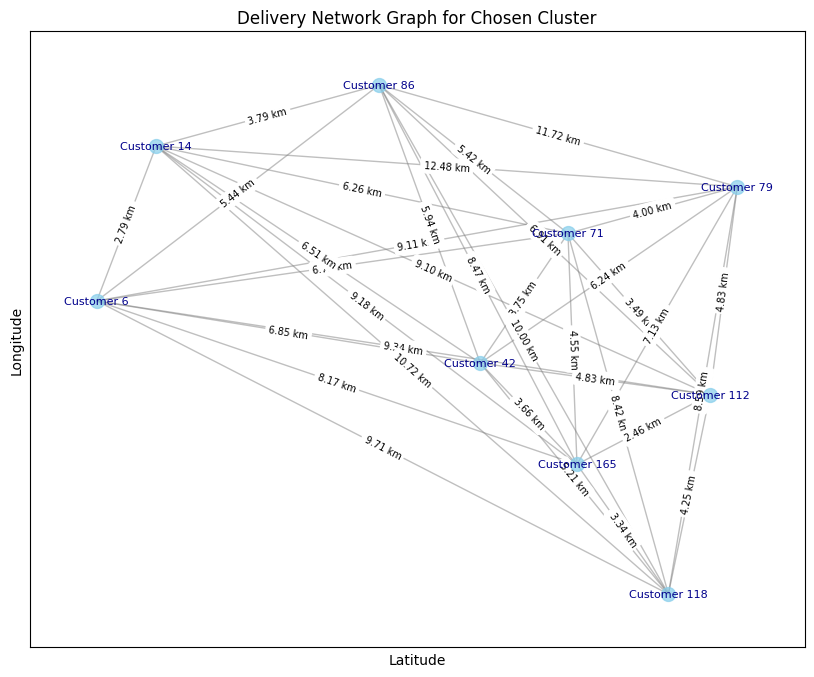

In [67]:
import matplotlib.pyplot as plt
import networkx as nx

# Function to visualize the graph
def visualize_graph(G):
    """Visualize the delivery network graph."""
    # Get positions of nodes for plotting
    pos = nx.get_node_attributes(G, 'pos')
    
    # Draw nodes and edges
    plt.figure(figsize=(10, 8))
    nx.draw_networkx_nodes(G, pos, node_size=100, node_color='skyblue', alpha=0.7)
    nx.draw_networkx_edges(G, pos, width=1, alpha=0.5, edge_color='gray')
    nx.draw_networkx_labels(G, pos, font_size=8, font_color="darkblue")
    
    # Display edge weights (distances in km)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f"{d:.2f} km" for u, v, d in G.edges(data='weight')}, font_size=7)
    
    # Display the plot
    plt.title("Delivery Network Graph for Chosen Cluster")
    plt.xlabel("Latitude")
    plt.ylabel("Longitude")
    plt.show()

# Select a cluster (e.g., from the '9-11 AM' time slot)
chosen_cluster = clustered_customers_with_personnel['9-11 AM'][clustered_customers_with_personnel['9-11 AM']['kmeans_cluster'] == 0]

# Create the graph for the chosen cluster
G = create_graph_for_cluster(chosen_cluster)

# Visualize the graph
visualize_graph(G)
